In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Tải bộ dữ liệu đã qua tiền xử lý
df = pd.read_csv('preprocessed_data.csv')
print(f"shape: {df.shape}")
df.head()

shape: (17562, 24)


,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,showers,snow_depth,cloud_cover,wind_speed_10m,month,hour,...,temperature_2m_lag2,relative_humidity_2m_lag1,relative_humidity_2m_lag2,surface_pressure_lag1,surface_pressure_lag2,pressure_trend,humidity_change,hour_sin,hour_cos,humidity_roll_mean_3h
0,21.6,92,20.2,1014.4,0.0,0.0,100,4.3,1,6,...,22.5,87.0,90.0,1013.9,1013.4,0.8,5.0,1.000000,6.123234e-17,89.666667
1,22.5,90,20.9,1014.9,0.0,0.0,100,2.9,1,7,...,22.9,92.0,87.0,1014.4,1013.9,1.5,-2.0,0.965926,-2.588190e-01,89.666667
2,23.5,89,21.5,1016.3,0.0,0.0,98,5.6,1,8,...,21.6,90.0,92.0,1014.9,1014.4,2.4,-1.0,0.866025,-5.000000e-01,90.333333
3,23.9,87,21.6,1016.5,0.0,0.0,83,6.4,1,9,...,22.5,89.0,90.0,1016.3,1014.9,2.1,-2.0,0.707107,-7.071068e-01,88.666667
4,24.8,82,21.6,1016.1,0.0,0.0,93,9.2,1,10,...,23.5,87.0,89.0,1016.5,1016.3,1.2,-5.0,0.500000,-8.660254e-01,86.000000


In [11]:
# Tách Features (X) và Target (y)
X = df.drop(columns=['weather_group'])
y = df['weather_group']

# Mã hóa nhãn từ chữ (Drizzle, Rain...) sang số (0, 1, 2...) 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Các lớp thời tiết:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

Các lớp thời tiết:
0: Cloudy
1: Drizzle
2: Rain


In [12]:
# Chia Train và tập tạm (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Chia tập tạm thành Validation và Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

Train: 12293 | Val: 2634 | Test: 2635


In [ ]:
scaler = StandardScaler() 

# Chỉ fit trên tập Train để tránh rò rỉ dữ liệu (Data Leakage)
X_train_scaled = scaler.fit_transform(X_train) 
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Khởi tạo mô hình Softmax
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)

# Thiết lập các tham số cần tối ưu
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Độ mạnh của Regularization
    'penalty': ['l2']               # L2 thường ổn định nhất cho Softmax
}

# Tìm kiếm tham số tốt nhất trên tập Train và đánh giá qua Cross-validation
grid_search = GridSearchCV(softmax_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"Tham số tốt nhất: {grid_search.best_params_}")

# Kiểm tra trên tập Validation
y_val_pred = best_model.predict(X_val_scaled)
print(f"Độ chính xác trên tập Validation: {accuracy_score(y_val, y_val_pred):.4f}")

c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will b

Tham số tốt nhất: {'C': 100, 'penalty': 'l2'}
Độ chính xác trên tập Validation: 0.7491


c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
# Dự đoán trên tập training để xem chi tiết
y_train_pred = best_model.predict(X_train_scaled) 
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TRAIN ---")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))
# Dự đoán trên tập Validation để xem chi tiết
y_val_pred = best_model.predict(X_val_scaled)
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP VALIDATION ---")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
# Dự đoán trên tập Test (dữ liệu hoàn toàn mới)
y_test_pred = best_model.predict(X_test_scaled) 
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print(f"Độ chính xác trên tập Train: {accuracy_score(y_train, best_model.predict(X_train_scaled)):.4f}")
print(f"Độ chính xác trên tập Val: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Độ chính xác trên tập Test: {accuracy_score(y_test, y_test_pred):.4f}")



--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TRAIN ---
              precision    recall  f1-score   support

      Cloudy       0.80      0.92      0.85      8168
     Drizzle       0.62      0.45      0.52      3387
        Rain       0.66      0.41      0.50       738

    accuracy                           0.76     12293
   macro avg       0.69      0.59      0.62     12293
weighted avg       0.74      0.76      0.74     12293

--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP VALIDATION ---
              precision    recall  f1-score   support

      Cloudy       0.79      0.91      0.84      1750
     Drizzle       0.61      0.44      0.51       725
        Rain       0.68      0.39      0.50       159

    accuracy                           0.75      2634
   macro avg       0.69      0.58      0.62      2634
weighted avg       0.73      0.75      0.73      2634

--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---
              precision    recall  f1-score   support

      Cloudy       0.80      0.91      0.85      1751
  

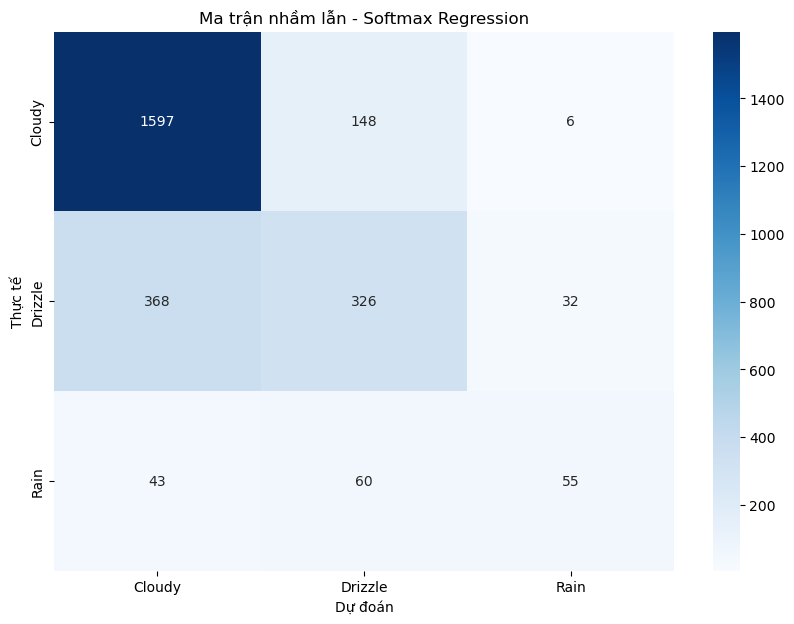

In [18]:
# Vẽ Confusion Matrix để xem mô hình nhầm lẫn giữa các loại thời tiết nào
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Softmax Regression')
plt.show()